In [ ]:
################################################################################
############################### INITIALIZE #####################################
################################################################################
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
filepath = "/kaggle/input/mesio-summer-school-2023"

# LASSO AND RIDGE

In [ ]:
# Warning "A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead" removing:
pd.options.mode.chained_assignment = None
pd.set_option("display.max_rows", 60, "display.max_columns", None)

# Read data
train = pd.read_csv(filepath + '/train.csv')
test = pd.read_csv(filepath + '/test.csv')


In [ ]:
################################################################################
################################# FEATURE ######################################
############################### ENGINEERING ####################################
################################################################################
# Features types
Features = train.dtypes.reset_index()
Categorical = Features.loc[Features[0] == 'object', 'index']
# Categorical to the begining
cols = train.columns.tolist()
pos = 0
for col in Categorical:
    cols.insert(pos, cols.pop(cols.index(col)))
    pos += 1
train = train[cols]
cols.remove('TARGET')
test = test[cols]

In [ ]:
# 1) Missings
################################################################################
# Function to print columns with at least n_miss missings

def miss(ds, n_miss):
    miss_list = list()
    for col in list(ds):
        if ds[col].isna().sum() >= n_miss:
            print(col, ds[col].isna().sum())
            miss_list.append(col)
    return miss_list


In [ ]:
# 1.1) Missings in categorical features (fix it with an 'NA' string)
################################################################################
for col in Categorical:
    train.loc[train[col].isna(), col] = 'NA'
    test.loc[test[col].isna(), col] = 'NA'

In [ ]:
# 1.2) Missings -> Drop some rows
################################################################################
# We can see a lot of colummns with 3 missings in train, look the data and...
# there are 4 observations that have many columns with missing values:
# A1039
# A2983
# A3055
# A4665
# ok, drop:
train = train[train['ID'] != 'A1039']
train = train[train['ID'] != 'A2983']
train = train[train['ID'] != 'A3055']
train = train[train['ID'] != 'A4665']

train.reset_index(drop=True, inplace=True)

print('\n################## TRAIN ##################')
m_tr = miss(train, 1)
print('\n################## TEST ##################')
m_te = miss(test, 1)

# Check that there are no missings only in test:
[i for i in m_te if i not in m_tr]

In [ ]:
# 1.3) Missings -> n_tile, max or min
################################################################################
# Now, we consider columns with "many" missings:
m_tr = miss(train, 30)

# And plot them to assign a percentile:

# Plot: Features with missing values to impute a value
# Bars = Population in each bucket (left axis)
# Line = Observed Default Frequency (ODF) (right axis)


def feat_graph(df, icol, binary_col, n_buckets):
    feat_data = df[[icol, binary_col]]
    feat_data['bucket'] = pd.qcut(
        feat_data.iloc[:, 0], q=n_buckets, labels=False, duplicates='drop')+1

    if len(feat_data.loc[feat_data[icol].isna(), 'bucket']) > 0:
        feat_data.loc[feat_data[icol].isna(), 'bucket'] = 0

    hist_data_p = pd.DataFrame(feat_data[['bucket', binary_col]].groupby(
        ['bucket'])[binary_col].mean()).reset_index()
    hist_data_N = pd.DataFrame(feat_data[['bucket', binary_col]].groupby(
        ['bucket'])[binary_col].count()).reset_index()
    hist_data = pd.merge(hist_data_N, hist_data_p, how='left', on='bucket')
    hist_data.columns = ['bucket', 'N', 'p']

    plt.figure()
    width = .70  # width of a bar
    hist_data['N'].plot(kind='bar', width=width, color='darkgray')
    hist_data['p'].plot(secondary_y=True, marker='o')

    ax = plt.gca()
    plt.xlim([-width, len(hist_data)-width/2])
    if len(feat_data.loc[feat_data[icol].isna(), 'bucket']) > 0:
        lab = ['Missing']
        for i in range(1, n_buckets+1):
            lab.append('G'+str(i))
        ax.set_xticklabels(lab)
    else:
        lab = []
        for i in range(1, n_buckets+1):
            lab.append('G'+str(i))
        ax.set_xticklabels(lab)

# # Plot
# for icol in list(m_tr):
#     feat_graph(train, icol, 'TARGET', 10)

# Decide assignation
assign_dict = dict.fromkeys(m_tr, 0)
assign_dict['X24'] = 0.8
assign_dict['X27'] = 'min'
assign_dict['X28'] = 0.1
assign_dict['X37'] = 0.1
assign_dict['X41'] = 0.3
assign_dict['X45'] = 0.1
assign_dict['X53'] = 0.1
assign_dict['X54'] = 0.1
assign_dict['X60'] = 'min'
assign_dict['X64'] = 'min'

# Create missing indicators
miss_dummy_tr = pd.DataFrame(
    0, index=np.arange(len(train[m_tr])), columns=m_tr)
miss_dummy_te = pd.DataFrame(0, index=np.arange(len(test[m_tr])), columns=m_tr)

for col in m_tr:
    miss_dummy_tr.loc[train[col].isna(), col] = 1
    miss_dummy_te.loc[test[col].isna(), col] = 1
    v = assign_dict[col]
    print('imputing ', col, ': ', v, sep='')
    if v == 'min':
        value = train[col].min()-1
        train.loc[train[col].isna(), col] = value
        test.loc[test[col].isna(), col] = value
    elif v == 'max':
        value = train[col].max()+1
        train.loc[train[col].isna(), col] = value
        test.loc[test[col].isna(), col] = value
    else:
        value = train[col].quantile(v)
        train.loc[train[col].isna(), col] = value
        test.loc[test[col].isna(), col] = value

miss_dummy_tr = miss_dummy_tr.add_suffix('_m')
miss_dummy_te = miss_dummy_te.add_suffix('_m')


In [ ]:
# 1.4) Missings -> Exotic techniques
################################################################################
# The remaining missings will be imputed via Iterative Imputer:
# Models each feature with missing values as a function of other features, and
# uses that estimate for imputation

X_train = train.drop(columns=Categorical, axis=1)
X_train.drop(columns='TARGET', axis=1, inplace=True)
X_test = test.drop(columns=Categorical, axis=1)

# Impute

filler = IterativeImputer()
X_train_filled = filler.fit_transform(X_train)
X_test_filled = filler.transform(X_test)

X_train_filled = pd.DataFrame(X_train_filled, columns=list(X_train))
X_test_filled = pd.DataFrame(X_test_filled, columns=list(X_test))

train = pd.concat(
    [train[Categorical], X_train_filled, train['TARGET']], axis=1)
test = pd.concat([test[Categorical], X_test_filled], axis=1)

In [ ]:
# 3) Constants
################################################################################
# Let's see if there is some constant column: There are no constant columns

Now, before we look at the **correlations** between variables, we calculate the AUC of each variable. Then we eliminate the correlated variables that have less AUC. We only do this for the normal variables, not the dummy ones.

In [ ]:
# 2) Correlations
################################################################################
# Let's see if certain columns are correlated
# or even that are the same with a "shift"
thresholdCorrelation = 0.6

#for icol in cols[4:]:
#   print('AUC',icol,': ', roc_auc_score(train['TARGET'], train[icol]))

def InspectCorrelated(df):
    corrMatrix = df.corr().abs()  # Correlation Matrix
    upperMatrix = corrMatrix.where(
        np.triu(np.ones(corrMatrix.shape), k=1).astype(bool))
    correlColumns = dict(zip(cols[4:],np.zeros(len(cols[4:]),dtype=int)))
    for col in upperMatrix.columns:
        correls = upperMatrix.loc[upperMatrix[col]
                                  > thresholdCorrelation, col].keys()
        if (len(correls) >= 1):
            print("\n", col, '->', end=" ")
            correls=list(correls)
            correls.insert(0,col)
            max_auc=roc_auc_score(train['TARGET'], train[col])
            max_correl=col
            ## 0 -> We dont know, 1 -> we keep it, 2 -> We drop it 
            for i in correls:
                if(roc_auc_score(train['TARGET'], train[i])>max_auc):
                    max_auc= roc_auc_score(train['TARGET'], train[i])
                    max_correl=i
                print(i, end=" ")
            correlColumns[max_correl]=1
            for i in correls:
                if(correlColumns[i]==0):
                    correlColumns[i]=2
            print(" ->",max_correl,max_auc)
    droppingcols=[k for k, v in correlColumns.items() if v == 2]
    print('\nSelected columns to drop:\n', droppingcols)
    return(droppingcols)

def InspectCorrelated_dummy(df):
    corrMatrix = df.corr().abs()  # Correlation Matrix
    upperMatrix = corrMatrix.where(
        np.triu(np.ones(corrMatrix.shape), k=1).astype(bool))
    correlColumns = []
    for col in upperMatrix.columns:
        correls = upperMatrix.loc[upperMatrix[col]
                                  > thresholdCorrelation, col].keys()
        if (len(correls) >= 1):
            correlColumns.append(col)
            print("\n", col, '->', end=" ")
            for i in correls:
                print(i, end=" ")
    print('\nSelected columns to drop:\n', correlColumns)
    return(correlColumns)

# Look at correlations in the original features
correlColumns = InspectCorrelated(train.iloc[:, len(Categorical):-1])
# Look at correlations in missing dummies
correlColumns_miss = InspectCorrelated_dummy(miss_dummy_tr)

# If we are ok, throw them:
train = train.drop(correlColumns, axis=1)
test = test.drop(correlColumns, axis=1)
miss_dummy_tr = miss_dummy_tr.drop(correlColumns_miss, axis=1)
miss_dummy_te = miss_dummy_te.drop(correlColumns_miss, axis=1)


We manually select the variables that we want to put an alert on, (alerts_list) and calculate them.

In [ ]:
# 4) Alerts
################################################################################

alerts_train = pd.DataFrame()
alerts_test = pd.DataFrame()
THRESHOLDS = list()
ACTIVATIONS = list()
TMRS = list()

print('\nAlerts...')
print('###########################################')
alerts_list=list(['X5','X13','X15','X27','X56','X41']) 
#'X11','X22','X35','X42','X39' (Alerts that we would want to put, 
#but variables are eliminated in the correlation phase)

for FACTOR in alerts_list:   ##list(train)[len(Categorical):-1]:
    # depth 1 tree
    dtree = DecisionTreeClassifier(max_depth=1)
    data_tree = train[[FACTOR, 'TARGET']
                      ].loc[~train[FACTOR].isna()].reset_index(drop=True)
    dtree.fit(data_tree[[FACTOR]], data_tree[['TARGET']])
    # Optimal split
    threshold = dtree.tree_.threshold[0]
    # Alert creation
    alerts_train[FACTOR] = train[FACTOR]
    alerts_train[FACTOR+'_b'] = np.zeros(len(train))
    alerts_test[FACTOR] = test[FACTOR]
    alerts_test[FACTOR+'_b'] = np.zeros(len(test))

    orientation = '<='
    if (len(alerts_train.loc[alerts_train[FACTOR] <= threshold, FACTOR+'_b']) < len(alerts_train.loc[alerts_train[FACTOR] > threshold, FACTOR+'_b'])):
        alerts_train.loc[alerts_train[FACTOR] <= threshold, FACTOR+'_b'] = 1
        alerts_test.loc[alerts_test[FACTOR] <= threshold, FACTOR+'_b'] = 1
    else:
        alerts_train.loc[alerts_train[FACTOR] > threshold, FACTOR+'_b'] = 1
        alerts_test.loc[alerts_test[FACTOR] > threshold, FACTOR+'_b'] = 1
        orientation = '>'

    # ACTIVATIONS
    activ = int(alerts_train[FACTOR+'_b'].sum())

    # TMR
    TMO = pd.DataFrame(pd.concat([alerts_train[FACTOR+'_b'], train['TARGET']],
                                 axis=1).groupby([FACTOR+'_b'])['TARGET'].mean()).reset_index()
    TMR = float(TMO.loc[TMO[FACTOR+'_b'] == 1,
                        'TARGET'].iloc[0])/train['TARGET'].mean()

    # Throw the original factor
    alerts_train.drop([FACTOR], axis=1, inplace=True)
    alerts_test.drop([FACTOR], axis=1, inplace=True)

    # Add THRESHOLDS, ACTIVATIONS and TMR to the sequence
    THRESHOLDS.append(orientation+str(round(threshold, 3)))
    ACTIVATIONS.append(activ)
    TMRS.append(TMR*100)


In [ ]:
# Severity table
severity = pd.DataFrame({'Alert': list(alerts_train),
                         'Threshold': THRESHOLDS,
                         'Activations (N)': ACTIVATIONS,
                         'TMR (%)': TMRS})
severity['LOG TMR'] = np.log(severity['TMR (%)']/100)
severity['ABS LOG TMR'] = severity['LOG TMR'].abs()

severity = severity.sort_values(
    by='ABS LOG TMR', ascending=False).reset_index(drop=True)

# Correlations between alerts
# First, we order them by its importance
alerts_train = alerts_train[severity['Alert']]
alerts_test = alerts_test[severity['Alert']]

thresholdCorrelation = 0.7
correlColumns = InspectCorrelated_dummy(alerts_train)

# If we are ok, throw them:
alerts_train = alerts_train.drop(correlColumns, axis=1)
alerts_test = alerts_test.drop(correlColumns, axis=1)
for col in correlColumns:
    severity = severity[severity['Alert'] != col].reset_index(drop=True)

# Throw alerts with low activation
severity = severity.loc[severity['Activations (N)'] >= 30, ].reset_index(
    drop=True)

# Throw alerts with low TMR (over 100) and high TMR under 100
severity = severity.loc[(severity['TMR (%)'] >= 200) | (
    severity['TMR (%)'] <= 50), ].reset_index(drop=True)

print(severity.to_string())

# Final set of alerts
alerts_train = alerts_train[severity['Alert']]
alerts_test = alerts_test[severity['Alert']]

# Impute LOG TMR to alert activation
for col in list(alerts_train):
    mult = (severity.loc[severity['Alert'] == col, ['LOG TMR']]).values[0][0]
    alerts_train[col] = alerts_train[col]*mult
    alerts_test[col] = alerts_test[col]*mult

# Add ALERTS feature to train and test
# TRAIN
alerts_train['ALERTS'] = alerts_train.sum(axis=1)
train['ALERTS'] = alerts_train['ALERTS']
# TEST
alerts_test['ALERTS'] = alerts_test.sum(axis=1)
test['ALERTS'] = alerts_test['ALERTS']

# Finally add missing dummies to datasets
train = pd.concat([train, miss_dummy_tr], axis=1)
test = pd.concat([test, miss_dummy_te], axis=1)

# Reorder columns (TARGET at the end)
cols = list(train)
cols.insert(len(cols), cols.pop(cols.index('TARGET')))
train = train.reindex(columns=cols)

We calculate the WOEs, and some of them are manually modified by looking at the graphics and editing the csv, and then imported. List of modifications (upgraded_list):
- X2 -> <5,6,7,8>
- X4 -> <456>
- X5 -> <3,4>,<6,7>
- X9 -> <8,9>
- X15 -> <3,4,5>
- X19 -> <5,6>
- X20 -> <3,4>,<8,9>
- X27 -> <6,7>
- X28 -> <6,7,8>
- X29 -> <4,5,6>,<8,9,10> does not work
- X30 -> <2,3>
- X32 -> <5,6>,<7,8>
- X39 -> <2,3>
- X42 -> <5,6>
- X45 -> <5,6,7>
- X47 -> <5,6>
- X57 Doesnt work
- X59 -> <5,6>

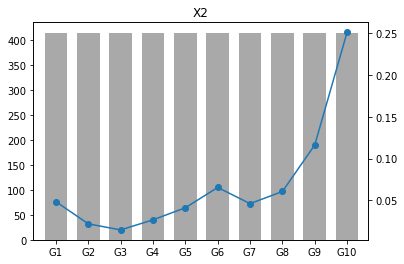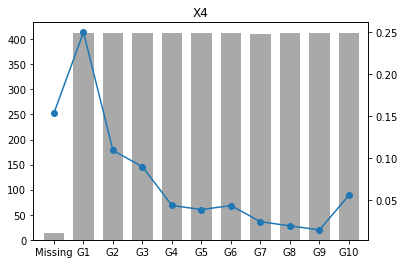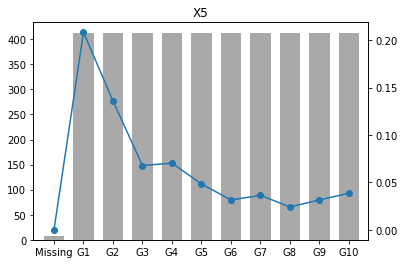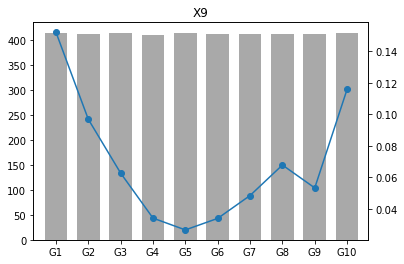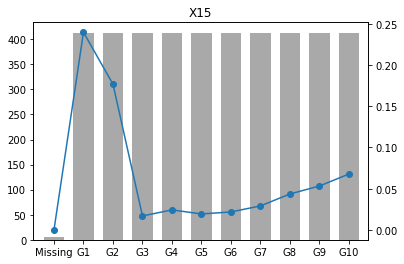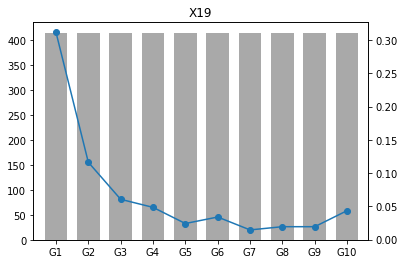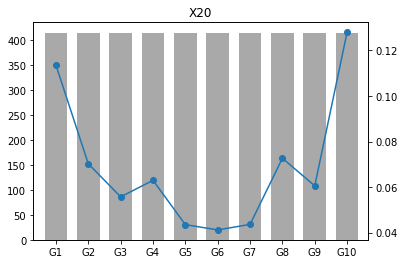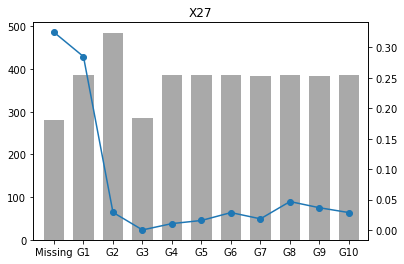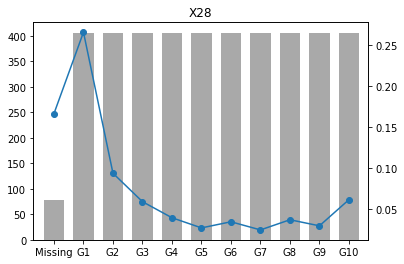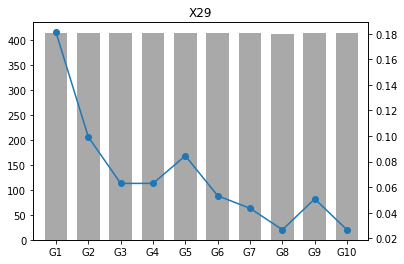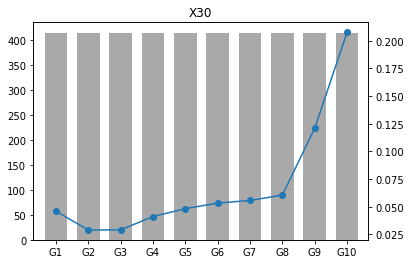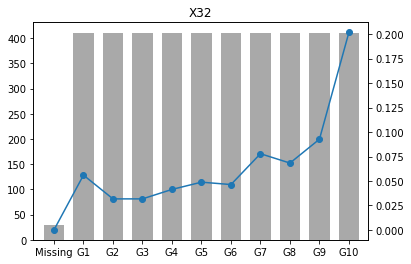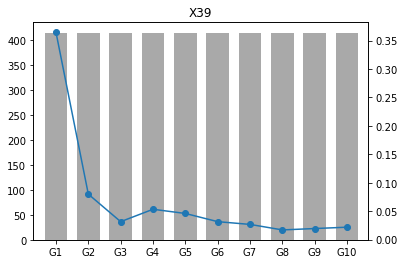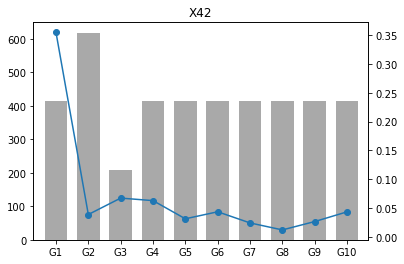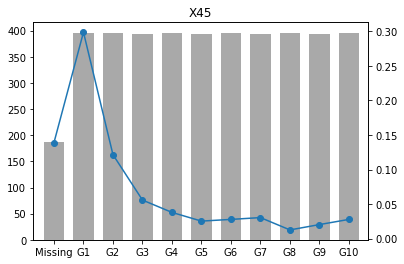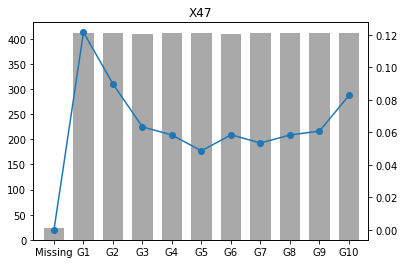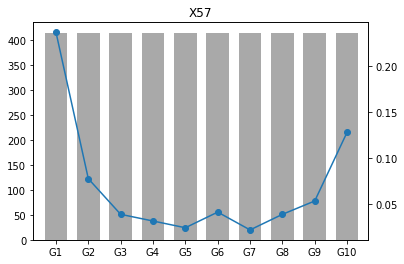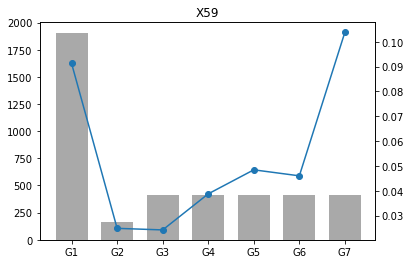

In [ ]:
# 5) WoE Transformation
################################################################################
# Woe Function
upgraded_list = ['X2','X4','X5','X9','X15','X19','X20','X27','X28','X30','X32','X39','X42','X45','X59']

def WoE(icol, binary_col, df_train, df_test, n_buckets=None):
    if n_buckets:
        df_train['bucket'], bins = pd.qcut(
            df_train[icol], q=n_buckets, labels=False, duplicates='drop', retbins=True)
        real_bins = len(bins)-1
        df_test['bucket'] = pd.cut(
            df_test[icol], bins=bins, labels=False, include_lowest=True)
        # If we are below the minimum or above the maximum in test assign the extreme buckets:
        df_test.loc[(df_test['bucket'].isna()) & (
            df_test[icol] >= max(bins)), 'bucket'] = real_bins-1
        df_test.loc[(df_test['bucket'].isna()) & (
            df_test[icol] <= min(bins)), 'bucket'] = 0
        woe_table = df_train[['bucket', binary_col]].groupby(
            ['bucket']).sum().reset_index()
    else:
        df_train['bucket'] = df_train[icol]
        df_test['bucket'] = df_test[icol]
        real_bins = len(df_train[icol].unique())
        woe_table = df_train[[icol, binary_col]].groupby(
            [icol]).sum().reset_index()
        woe_table = woe_table.rename(columns={icol: 'bucket'})

    # GOOD & BAD Total
    BAD = df_train[binary_col].sum()
    GOOD = df_train.loc[~df_train[binary_col].isna(), binary_col].count()-BAD

    # We have at least 2 values
    if real_bins >= 2:
        woe_table = woe_table.rename(columns={binary_col: 'BAD'})  # Defaults
        woe_table['TOTAL'] = df_train[['bucket', binary_col]].groupby(
            ['bucket']).count().reset_index()[binary_col]  # Totales
        woe_table['GOOD'] = (woe_table['TOTAL'] -
                             woe_table['BAD']).astype(int)  # Buenos

        # WoE by bucket
        woe_table['WOE'] = np.log(
            ((woe_table['GOOD']+0.001)/GOOD)/((woe_table['BAD']+0.001)/BAD))
        if(icol in upgraded_list):
            woe_table = pd.read_csv('/kaggle/input/modified-woes/WOE/Woe_'+icol+'_2.csv')
        # Add the new factor and remove the original
        df_train = pd.merge(
            df_train, woe_table[['bucket', 'WOE']], on='bucket', how='left')
        df_train = df_train.rename(columns={'WOE': icol+"_W"})
        df_train = df_train.drop(icol, axis=1)
        df_train = df_train.drop('bucket', axis=1)

        df_test = pd.merge(
            df_test, woe_table[['bucket', 'WOE']], on='bucket', how='left')
        # In case that for a Categorical variable (for Numerical variables this
        # is impossible since we have assigned every observation to a bin)
        # there are unseen categories in test (not found in train)
        # -> assign WoE = 0 (neutral WoE)
        df_test.loc[df_test['WOE'].isna(), 'WOE'] = 0
        df_test = df_test.rename(columns={'WOE': icol+"_W"})
        df_test = df_test.drop(icol, axis=1)
        df_test = df_test.drop('bucket', axis=1)
    else:
        print('Column ', icol, ' has less than 2 buckets -> Removed')
        df_train = df_train.drop(icol, axis=1)
        df_train = df_train.drop('bucket', axis=1)
        df_test = df_test.drop(icol, axis=1)
        df_test = df_test.drop('bucket', axis=1)

    return df_train, df_test


# List of features that we will treat as Categorical for WoE
As_Categorical = Categorical.tolist()
As_Categorical.remove('ID')
miss_dummies = [i for i in list(train) if '_m' in i]
for i in miss_dummies:
    As_Categorical.append(i)

# List of features that we will treat as Numerical for WoE
As_Numerical = list(train)
As_Numerical.remove('ID')
As_Numerical.remove('TARGET')
for i in As_Categorical:
    As_Numerical.remove(i)

# Initialize woe (or lineal) sets for modeling
train_woe = train.copy()
test_woe = test.copy()

# Transform Categorical
for icol in As_Categorical:
    train_woe, test_woe = WoE(icol=icol,
                              binary_col='TARGET',
                              df_train=train_woe,
                              df_test=test_woe,
                              n_buckets=None)
# Transform Numerical
for icol in As_Numerical:
    train_woe, test_woe = WoE(icol=icol,
                              binary_col='TARGET',
                              df_train=train_woe,
                              df_test=test_woe,
                              n_buckets=10)
cols = list(train_woe)
cols.insert(len(cols), cols.pop(cols.index('TARGET')))
train_woe = train_woe.reindex(columns=cols)

# Define final sets:
pred = list(train_woe)[1:-1]
X_train_woe = train_woe[pred].reset_index(drop=True)
Y_train = train_woe['TARGET'].reset_index(drop=True)
X_test_woe = test_woe[pred].reset_index(drop=True)

First we calculate the LASSO, then the RIDGE

In [ ]:
################################################################################
########################### MODEL LASSO / RIDGE ################################
######################### k-Fold Cross-Validation ##############################
################################################################################

# 1) k-Fold Cross-Validation Function
################################################################################


def Model_cv(MODEL, k, X_train, X_test, y, RE, makepred=True, CatPos=None):
    # Create the k folds
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=RE)

    # first level train and test
    Level_1_train = pd.DataFrame(
        np.zeros((X_train.shape[0], 1)), columns=['train_yhat'])
    if makepred == True:
        Level_1_test = pd.DataFrame()

    # Main loop for each fold. Initialize counter
    count = 0
    for train_index, test_index in kf.split(X_train, Y_train):
        count += 1
        # Define train and test depending in which fold are we
        fold_train = X_train.loc[train_index.tolist(), :]
        fold_test = X_train.loc[test_index.tolist(), :]
        fold_ytrain = y[train_index.tolist()]
        fold_ytest = y[test_index.tolist()]

        # (k-1)-folds model adjusting
        if CatPos:
            # Prepare Pool
            pool_train = Pool(fold_train, fold_ytrain, cat_features=Pos)
            # (k-1)-folds model adjusting
            model_fit = MODEL.fit(X=pool_train)

        else:
            # (k-1)-folds model adjusting
            model_fit = MODEL.fit(fold_train, fold_ytrain)

        # Predict on the free fold to evaluate metric
        # and on train to have an overfitting-free prediction for the next level
        p_fold = MODEL.predict_proba(fold_test)[:, 1]
        p_fold_train = MODEL.predict_proba(fold_train)[:, 1]

        # Score in the free fold
        score = roc_auc_score(fold_ytest, p_fold)
        score_train = roc_auc_score(fold_ytrain, p_fold_train)
        print(k, '-cv, Fold ', count, '\t --test AUC: ', round(score, 4),
              '\t--train AUC: ', round(score_train, 4), sep='')
        # Save in Level_1_train the "free" predictions concatenated
        Level_1_train.loc[test_index.tolist(), 'train_yhat'] = p_fold

        # Predict in test to make the k model mean
        # Define name of the prediction (p_"iteration number")
        if makepred == True:
            name = 'p_' + str(count)
            # Predictin to real test
            real_pred = MODEL.predict_proba(X_test)[:, 1]
            # Name
            real_pred = pd.DataFrame({name: real_pred}, columns=[name])
            # Add to Level_1_test
            Level_1_test = pd.concat((Level_1_test, real_pred), axis=1)

    # Compute the metric of the total concatenated prediction (and free of overfitting) in train
    score_total = roc_auc_score(y, Level_1_train['train_yhat'])
    print('\n', k, '- cv, TOTAL AUC:', round((score_total)*100, 4), '%')

    # mean of the k predictions in test
    if makepred == True:
        Level_1_test['model'] = Level_1_test.mean(axis=1)

    # Return train and test sets with predictions and the performance
    if makepred == True:
        return Level_1_train, pd.DataFrame({'test_yhat': Level_1_test['model']}), score_total
    else:
        return score_total

In [ ]:
# 2) k-fold Cross Validation execution
################################################################################

# Parameters of the CV
RS = 4321  # Seed for k-fold partition and model random part
n_folds = 5  # Number of folds

# Parameters of the model
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
params = {'penalty': 'l1',  # l1 is for Lasso, l2 for ridge
          'solver': 'liblinear',
          'random_state': RS}

MODEL = LogisticRegression()
MODEL.set_params(**params)

# We will define the model for various C's and make a search for the optimum
Cs = [0.1, 0.3, 0.5, 0.7, 1, 1.3]  # LASSO

print('\Linear CV...')
print('########################################################')
scores = []
for c in Cs:
    MODEL.set_params(C=c)
    print('\nRegularization C: ', c)
    Pred_train, Pred_test, s = Model_cv(
        MODEL, n_folds, X_train_woe, X_test_woe, Y_train, RS, makepred=True)

    # Look if we are in the first test:
    if len(scores) == 0:
        max_score = float('-inf')
    else:
        max_score = max(scores)

    # If the score improves, we keep this one:
    if s >= max_score:
        print('BEST')
        Linear_train = Pred_train.copy()
        Linear_test = Pred_test.copy()

    # Append score
    scores.append(s)

# The best cross-validated score has been found in:
best_C = Cs[scores.index(max(scores))]
print('\n###########################################')
print('Linear optimal C: ', best_C)
print('Linear optimal GINI: ', round((max(scores)*2-1)*100, 4), '%')
print('Linear optimal AUC: ', round(max(scores)*100, 4), '%')
print('###########################################')

In [ ]:
# 3) Model on all train with optimal hyper-parametrs
################################################################################
# best_C=0.5 # Manual C
model_linear = LogisticRegression()
model_linear.set_params(**params)
model_linear.set_params(C=best_C)

model_linear.fit(X_train_woe, Y_train)
weights = pd.DataFrame({'feature': np.array(
    X_train_woe.columns), 'coefs': np.transpose(np.array(model_linear.coef_))[:, 0]})
weights = weights.sort_values(
    by='coefs', ascending=True).reset_index(drop=True)

################################################################################
# Results
# Prediction
test['Pred'] = model_linear.predict_proba(X_test_woe)[:, 1]
linear_submission = pd.DataFrame(test[['ID', 'Pred']])

# Cv predictions
linear_cv_train = train[['ID']]
linear_cv_train['linear_pred'] = Linear_train['train_yhat']
linear_cv_test = test[['ID']]
linear_cv_test['linear_pred'] = Linear_test['test_yhat']

In [ ]:
# Outputs to .csv
# Lasso
linear_submission.to_csv("lasso_submission.csv", index=False)
linear_cv_train.to_csv("lasso_cv_train.csv", index=False)
linear_cv_test.to_csv("lasso_cv_test.csv", index=False)
weights.to_csv("lasso_features.csv", index=False)
################################################################################

Now we calculate the RIDGE

In [ ]:
# 2) k-fold Cross Validation execution
################################################################################

# Parameters of the CV
RS = 4321  # Seed for k-fold partition and model random part
n_folds = 5  # Number of folds

# Parameters of the model
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
params = {'penalty': 'l2',  # l1 is for Lasso, l2 for ridge
          'solver': 'liblinear',
          'random_state': RS}

MODEL = LogisticRegression()
MODEL.set_params(**params)

# We will define the model for various C's and make a search for the optimum
Cs=[0.01,0.012,0.014] # Ridge

print('\Linear CV...')
print('########################################################')
scores = []
for c in Cs:
    MODEL.set_params(C=c)
    print('\nRegularization C: ', c)
    Pred_train, Pred_test, s = Model_cv(
        MODEL, n_folds, X_train_woe, X_test_woe, Y_train, RS, makepred=True)

    # Look if we are in the first test:
    if len(scores) == 0:
        max_score = float('-inf')
    else:
        max_score = max(scores)

    # If the score improves, we keep this one:
    if s >= max_score:
        print('BEST')
        Linear_train = Pred_train.copy()
        Linear_test = Pred_test.copy()

    # Append score
    scores.append(s)

# The best cross-validated score has been found in:
best_C = Cs[scores.index(max(scores))]
print('\n###########################################')
print('Linear optimal C: ', best_C)
print('Linear optimal GINI: ', round((max(scores)*2-1)*100, 4), '%')
print('Linear optimal AUC: ', round(max(scores)*100, 4), '%')
print('###########################################')

In [ ]:
# 3) Model on all train with optimal hyper-parametrs
################################################################################
# best_C=0.5 # Manual C
model_linear = LogisticRegression()
model_linear.set_params(**params)
model_linear.set_params(C=best_C)

model_linear.fit(X_train_woe, Y_train)
weights = pd.DataFrame({'feature': np.array(
    X_train_woe.columns), 'coefs': np.transpose(np.array(model_linear.coef_))[:, 0]})
weights = weights.sort_values(
    by='coefs', ascending=True).reset_index(drop=True)

################################################################################
# Results
# Prediction
test['Pred'] = model_linear.predict_proba(X_test_woe)[:, 1]
linear_submission = pd.DataFrame(test[['ID', 'Pred']])

# Cv predictions
linear_cv_train = train[['ID']]
linear_cv_train['linear_pred'] = Linear_train['train_yhat']
linear_cv_test = test[['ID']]
linear_cv_test['linear_pred'] = Linear_test['test_yhat']

In [ ]:
# Outputs to .csv
# Ridge
linear_submission.to_csv("ridge_submission.csv", index=False)
linear_cv_train.to_csv("ridge_cv_train.csv", index=False)
linear_cv_test.to_csv("ridge_cv_test.csv", index=False)
weights.to_csv("ridge_features.csv", index=False)
################################################################################

# Catboost

In [ ]:
################################################################################
############################### INITIALIZE #####################################
################################################################################
import seaborn as sns
import matplotlib.pyplot as plt
from shap import summary_plot
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from catboost import Pool
from catboost import CatBoostClassifier
import os
import pandas as pd  # Install version 1.5.3 (iteritems errors)
import numpy as np
import warnings
filepath = "/kaggle/input/mesio-summer-school-2023"
# Remove warning iteritems in Pool
warnings.simplefilter(action='ignore', category=FutureWarning)

# Read data
train = pd.read_csv(filepath + '/train.csv')
test = pd.read_csv(filepath + '/test.csv')

# Warning "A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead" removing:
pd.options.mode.chained_assignment = None
pd.set_option("display.max_rows", 50, "display.max_columns", None)

################################################################################
################################# FEATURE ######################################
############################### ENGINEERING ####################################
################################################################################
# Feature types
Features = train.dtypes.reset_index()
Categorical = Features.loc[Features[0] == 'object', 'index']

# Categorical to the begining
cols = train.columns.tolist()
pos = 0
for col in Categorical:
    cols.insert(pos, cols.pop(cols.index(col)))
    pos += 1
train = train[cols]
cols.remove('TARGET')
test = test[cols]


# 1) Missings
################################################################################
# Function to print columns with at least n_miss missings
def miss(ds, n_miss):
    miss_list = list()
    for col in list(ds):
        if ds[col].isna().sum() >= n_miss:
            print(col, ds[col].isna().sum())
            miss_list.append(col)
    return miss_list


# Which columns have 1 missing at least...
print('\n################## TRAIN ##################')
m_tr = miss(train, 1)
print('\n################## TEST ##################')
m_te = miss(test, 1)

# Missings in categorical features (fix it with an 'NA' string)
################################################################################
for col in Categorical:
    train.loc[train[col].isna(), col] = 'NA'
    test.loc[test[col].isna(), col] = 'NA'

# Missings -> Drop some rows
################################################################################
# We can see a lot of colummns with 3 missings in train, look the data and...
# there are 4 observations that have many columns with missing values:
# A1039
# A2983
# A3055
# A4665
train = train[train['ID'] != 'A1039']
train = train[train['ID'] != 'A2983']
train = train[train['ID'] != 'A3055']
train = train[train['ID'] != 'A4665']

train.reset_index(drop=True, inplace=True)

# 2) Correlations
################################################################################
# Let's see if certain columns are correlated
# or even that are the same with a "shift"
thresholdCorrelation = 0.99


def InspectCorrelated(df):
    corrMatrix = df.corr().abs()  # Correlation Matrix
    upperMatrix = corrMatrix.where(
        np.triu(np.ones(corrMatrix.shape), k=1).astype(bool))
    correlColumns = []
    for col in upperMatrix.columns:
        correls = upperMatrix.loc[upperMatrix[col]
                                  > thresholdCorrelation, col].keys()
        if len(correls) >= 1:
            correlColumns.append(col)
            print("\n", col, '->', end=" ")
            for i in correls:
                print(i, end=" ")
    print('\nSelected columns to drop:\n', correlColumns)
    return correlColumns


# Look at correlations in the original features
correlColumns = InspectCorrelated(train.iloc[:, len(Categorical):-1])

# If we are ok, throw them:
train = train.drop(correlColumns, axis=1)
test = test.drop(correlColumns, axis=1)


# 3) Constants
################################################################################
# Let's see if there is some constant column:
def InspectConstant(df):
    consColumns = []
    for col in list(df):
        if len(df[col].unique()) < 2:
            print(df[col].dtypes, '\t', col, len(df[col].unique()))
            consColumns.append(col)
    print('\nSelected columns to drop:\n', consColumns)
    return consColumns


consColumns = InspectConstant(train.iloc[:, len(Categorical):-1])

# If we are ok, throw them:
train = train.drop(consColumns, axis=1)
test = test.drop(consColumns, axis=1)

################################################################################
################################ MODEL CATBOOST ################################
################################# TRAIN / TEST #################################
################################################################################
pred = list(train)[1:-1]
X_train = train[pred].reset_index(drop=True)
Y_train = train['TARGET'].reset_index(drop=True)
X_test = test[pred].reset_index(drop=True)

# 1) For expensive models (catboost) we first try with validation set (no cv)
################################################################################

# train / test partition
RS = 1200  # Seed for partitions (train/test) and model random part
TS = 0.3  # Validation size
# Early stopping rounds (when validation does not improve in these rounds, stops)
esr = 150


x_tr, x_val, y_tr, y_val = train_test_split(
    X_train, Y_train, test_size=TS, random_state=RS)

# Categorical positions for catboost
Pos = list()
As_Categorical = Categorical.tolist()
As_Categorical.remove('ID')
for col in As_Categorical:
    Pos.append((X_train.columns.get_loc(col)))

# To Pool Class (for catboost only)
pool_tr = Pool(x_tr, y_tr, cat_features=Pos)
pool_val = Pool(x_val, y_val, cat_features=Pos)

# By-hand paramter tuning. A grid-search is expensive
# We test different combinations
# See parameter options here:
# "https://catboost.ai/en/docs/references/training-parameters/"
model_catboost_val = CatBoostClassifier(
    eval_metric='AUC',
    iterations=2500,  # Very high value, to find the optimum
    od_type='Iter',  # Overfitting detector set to "iterations" or number of trees
    random_seed=RS,  # Random seed for reproducibility
    verbose=100)  # Shows train/test metric every "verbose" trees

# "Technical" parameters of the model:
params = {'objective': 'Logloss',
          'learning_rate': 0.01,  # learning rate, lower -> slower but better prediction
          # Depth of the trees (values betwwen 5 and 10, higher -> more overfitting)
          'depth':7,
          'min_data_in_leaf': 50,
          # L2 regularization (between 3 and 20, higher -> less overfitting)
          'l2_leaf_reg': 13,
          # % of features to consider in each split (lower -> faster and reduces overfitting)
          'rsm': 0.5,
          'subsample': 0.7,  # Sample rate for bagging
          'random_seed': RS}

model_catboost_val.set_params(**params)

print('\nCatboost Fit (Validation)...\n')
model_catboost_val.fit(X=pool_tr,
                       eval_set=pool_val,
                       early_stopping_rounds=esr)

################################################################################
################################ MODEL CATBOOST ################################
########################### k-Fold Cross-Validation ############################
################################################################################

# 1) k-Fold Cross-Validation Function
################################################################################


def Model_cv(MODEL, k, X_train, X_test, y, RS, makepred=True, CatPos=None):
    # Create the k folds
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=RS)

    # first level train and test
    Level_1_train = pd.DataFrame(
        np.zeros((X_train.shape[0], 1)), columns=['train_yhat'])
    if makepred:
        Level_1_test = pd.DataFrame()

    # Main loop for each fold. Initialize counter
    count = 0
    for train_index, test_index in kf.split(X_train, Y_train):
        count += 1
        # Define train and test depending in which fold are we
        fold_train = X_train.loc[train_index.tolist(), :]
        fold_test = X_train.loc[test_index.tolist(), :]
        fold_ytrain = y[train_index.tolist()]
        fold_ytest = y[test_index.tolist()]

        # (k-1)-folds model adjusting
        if CatPos:
            # Prepare Pool
            pool_train = Pool(fold_train, fold_ytrain, cat_features=Pos)
            # (k-1)-folds model adjusting
            model_fit = MODEL.fit(X=pool_train)

        else:
            # (k-1)-folds model adjusting
            model_fit = MODEL.fit(fold_train, fold_ytrain)

        # Predict on the free fold to evaluate metric
        # and on train to have an overfitting-free prediction for the next level
        p_fold = MODEL.predict_proba(fold_test)[:, 1]
        p_fold_train = MODEL.predict_proba(fold_train)[:, 1]

        # Score in the free fold
        score = roc_auc_score(fold_ytest, p_fold)
        score_train = roc_auc_score(fold_ytrain, p_fold_train)
        print(k, '-cv, Fold ', count, '\t --test AUC: ', round(score, 4), '\t--train AUC: ', round(score_train, 4),
              sep='')
        # Save in Level_1_train the "free" predictions concatenated
        Level_1_train.loc[test_index.tolist(), 'train_yhat'] = p_fold

        # Predict in test to make the k model mean
        # Define name of the prediction (p_"iteration number")
        if makepred:
            name = 'p_' + str(count)
            # Predictin to real test
            real_pred = MODEL.predict_proba(X_test)[:, 1]
            # Name
            real_pred = pd.DataFrame({name: real_pred}, columns=[name])
            # Add to Level_1_test
            Level_1_test = pd.concat((Level_1_test, real_pred), axis=1)

    # Compute the metric of the total concatenated prediction (and free of overfitting) in train
    score_total = roc_auc_score(y, Level_1_train['train_yhat'])
    print('\n', k, '- cv, TOTAL AUC:', round((score_total) * 100, 4), '%')

    # mean of the k predictions in test
    if makepred:
        Level_1_test['model'] = Level_1_test.mean(axis=1)

    # Return train and test sets with predictions and the performance
    if makepred:
        return Level_1_train, pd.DataFrame({'test_yhat': Level_1_test['model']}), score_total
    else:
        return score_total


# 2) k-Fold Cross-Validation Implementattion
################################################################################
# Parameters of the CV
RS = 1200  # Seed for k-fold partition and model random part
# Number of folds (depends on the sample size, the proportion of 1's over 0's,...)
n_folds = 5

# Put in the "iter" list various values around the discovered in the previous step:
# (The number of iterations is altered proportionaly in function of the
# datasets sizes (where has been obtained and where has to be applied))
nrounds_cv = round(model_catboost_val.best_iteration_ /
                   (1 - TS) * (1 - 1 / n_folds))
iter = [round(nrounds_cv * 0.9), nrounds_cv, round(nrounds_cv * 1.1)]

print('\nCatboost CV...')
print('########################################################')
scores = []
for nrounds in iter:

    print('\nn rounds: ', nrounds)

    # Define the model
    model_catboost_cv = CatBoostClassifier()
    model_catboost_cv.set_params(**params)
    model_catboost_cv.set_params(n_estimators=nrounds)
    model_catboost_cv.set_params(verbose=False)

    Pred_train, Pred_test, s = Model_cv(model_catboost_cv, n_folds, X_train, X_test, Y_train, RS, makepred=True,
                                        CatPos=Pos)

    # Look if we are in the first test:
    if len(scores) == 0:
        max_score = float('-inf')
    else:
        max_score = max(scores)

    # If the score improves, we keep this one:
    if s >= max_score:
        print('BEST')
        Catboost_train = Pred_train.copy()
        Catboost_test = Pred_test.copy()

    # Append score
    scores.append(s)

# The best cross-validated score has been found in:
print('\n###########################################')
print('Catboost optimal rounds: ', iter[scores.index(max(scores))])
print('Catboost optimal GINI: ', round((max(scores) * 2 - 1) * 100, 4), '%')
print('Catboost optimal AUC: ', round(max(scores) * 100, 4), '%')
print('###########################################')

# 3) Train a model on whole train with the optimal parameters:
################################################################################

# Adjust optimal CV number of rounds to whole sample size:
nrounds = int(iter[scores.index(max(scores))] / (1 - 1 / n_folds))

# Define the optimal model
model_catboost = CatBoostClassifier(n_estimators=nrounds,
                                    random_seed=RS,
                                    verbose=100)
model_catboost.set_params(**params)

# To Pool Class (for catboost only)
pool_train = Pool(X_train, Y_train, cat_features=Pos)

# Fit the model
print('\nCatboost Optimal Fit with %d rounds...\n' % nrounds)
model_catboost.fit(X=pool_train)

# 4) Shap Importance for the features of the final model
################################################################################
# Shap methodology:
# "https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83"
# Catboost has already SHAP integrated
# Comes as variation with respect to LOG Odds
ShapImportance = model_catboost.get_feature_importance(data=pool_train,
                                                       type='ShapValues',
                                                       prettified=True,
                                                       verbose=False)
ShapValues = ShapImportance.iloc[:, :-1]
ShapValues.columns = list(X_train)

# Picture in Logodds
################################################################################

num_features = 30
summary_plot(ShapValues.values, X_train, max_display=num_features,
             plot_type='dot', plot_size=[8, 8])

# Variable Importance Recap
################################################################################

Importance = ShapValues.abs().mean(axis=0)
Importance = pd.DataFrame(
    {'Feature': Importance.index.tolist(), 'Importance': Importance})
Importance.sort_values(by=['Importance'], ascending=False, inplace=True)
Importance.reset_index(inplace=True, drop=True)

# Top features:
plt.figure(figsize=(10, 10))
sns.barplot(x="Importance",
            y="Feature",
            data=Importance[:num_features],
            palette=sns.color_palette("Blues_d",
                                      n_colors=Importance[:num_features].shape[0]))

################################################################################
################################### RESULTS ####################################
################################################################################

# Prediction (All train model)
test['Pred'] = model_catboost.predict_proba(X_test)[:, 1]
catboost_submission = pd.DataFrame(test[['ID', 'Pred']])

# Cv predictions
catboost_cv_train = train[['ID']]
catboost_cv_train['catboost_pred'] = Catboost_train['train_yhat']
catboost_cv_test = test[['ID']]
catboost_cv_test['catboost_pred'] = Catboost_test['test_yhat']

# Outputs to .csv
catboost_submission.to_csv("catboost_submission.csv", index=False)
catboost_cv_train.to_csv("catboost_cv_train.csv", index=False)
catboost_cv_test.to_csv("catboost_cv_test.csv", index=False)
Importance.to_csv("catboost_importance.csv", index=False)

# Stacking with catboost

In [ ]:
################################################################################
############################### INITIALIZE #####################################
################################################################################
import numpy as np
import pandas as pd
import os
import warnings
filepath1 = "/kaggle/input/mesio-summer-school-2023"
filepath2 = "/kaggle/working/"

warnings.simplefilter(action='ignore', category=FutureWarning) # Remove warning iteritems in Pool
# Warning "A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead" removing:
pd.options.mode.chained_assignment = None
pd.set_option("display.max_rows", 60, "display.max_columns", None)

# Read data
catboost_cv_train = pd.read_csv(filepath2 + '/catboost_cv_train.csv')
lasso_cv_train = pd.read_csv(filepath2 + 'lasso_cv_train.csv')
ridge_cv_train = pd.read_csv(filepath2 + 'ridge_cv_train.csv')
catboost_cv_test = pd.read_csv(filepath2 + 'catboost_cv_test.csv')
lasso_cv_test = pd.read_csv(filepath2 + 'lasso_cv_test.csv')
ridge_cv_test = pd.read_csv(filepath2 + 'ridge_cv_test.csv')

# Read data
train = pd.read_csv(filepath1 + '/train.csv')
test = pd.read_csv(filepath1 + '/test.csv')

train = train[train['ID'] != 'A1039']
train = train[train['ID'] != 'A2983']
train = train[train['ID'] != 'A3055']
train = train[train['ID'] != 'A4665']

train.reset_index(drop=True, inplace=True)


################################################################################
############################# LEVEL 1: MODEL ###################################
################################################################################

# New train and test
################################################################################

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def lodds(x):
    return np.log(x / (1 - x))


X1_train = pd.DataFrame({
    "Catboost": lodds(catboost_cv_train['catboost_pred']),
    "Lasso": lodds(lasso_cv_train['linear_pred']),
    "Ridge": lodds(ridge_cv_train['linear_pred'])
})

X1_test = pd.DataFrame({
    "Catboost": lodds(catboost_cv_test['catboost_pred']),
    "Lasso": lodds(lasso_cv_test['linear_pred']),
    "Ridge": lodds(ridge_cv_test['linear_pred'])
})

Y_train = train['TARGET']

# k-Fold Cross-Validation Function
################################################################################
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


def Model_cv(MODEL, k, X_train, X_test, y, RS, makepred=True, CatPos=None):
    # Create the k folds
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=RS)

    # first level train and test
    Level_1_train = pd.DataFrame(np.zeros((X_train.shape[0], 1)), columns=['train_yhat'])
    if makepred:
        Level_1_test = pd.DataFrame()

    # Main loop for each fold. Initialize counter
    count = 0
    for train_index, test_index in kf.split(X_train, Y_train):
        count += 1
        # Define train and test depending in which fold are we
        fold_train = X_train.loc[train_index.tolist(), :]
        fold_test = X_train.loc[test_index.tolist(), :]
        fold_ytrain = y[train_index.tolist()]
        fold_ytest = y[test_index.tolist()]

        # (k-1)-folds model adjusting
        if CatPos:
            # Prepare Pool
            pool_train = Pool(fold_train, fold_ytrain, cat_features=Pos)
            # (k-1)-folds model adjusting
            model_fit = MODEL.fit(X=pool_train)

        else:
            # (k-1)-folds model adjusting
            model_fit = MODEL.fit(fold_train, fold_ytrain)

        # Predict on the free fold to evaluate metric
        # and on train to have an overfitting-free prediction for the next level
        p_fold = MODEL.predict_proba(fold_test)[:, 1]
        p_fold_train = MODEL.predict_proba(fold_train)[:, 1]

        # Score in the free fold
        score = roc_auc_score(fold_ytest, p_fold)
        score_train = roc_auc_score(fold_ytrain, p_fold_train)
        print(k, '-cv, Fold ', count, '\t --test AUC: ', round(score, 4), '\t--train AUC: ', round(score_train, 4),
              sep='')
        # Save in Level_1_train the "free" predictions concatenated
        Level_1_train.loc[test_index.tolist(), 'train_yhat'] = p_fold

        # Predict in test to make the k model mean
        # Define name of the prediction (p_"iteration number")
        if makepred:
            name = 'p_' + str(count)
            # Predictin to real test
            real_pred = MODEL.predict_proba(X_test)[:, 1]
            # Name
            real_pred = pd.DataFrame({name: real_pred}, columns=[name])
            # Add to Level_1_test
            Level_1_test = pd.concat((Level_1_test, real_pred), axis=1)

    # Compute the metric of the total concatenated prediction (and free of overfitting) in train
    score_total = roc_auc_score(y, Level_1_train['train_yhat'])
    print('\n', k, '- cv, TOTAL AUC:', round((score_total) * 100, 4), '%')

    # mean of the k predictions in test
    if makepred:
        Level_1_test['model'] = Level_1_test.mean(axis=1)

    # Return train and test sets with predictions and the performance
    if makepred:
        return Level_1_train, pd.DataFrame({'test_yhat': Level_1_test['model']}), score_total
    else:
        return score_total


# LightGBM Level 1 Model
################################################################################
from catboost import CatBoostClassifier
from catboost import Pool

# Parameters of the CV
RS = 1234  # Seed for k-fold partition and model random part
n_folds = 5  # Number of folds

# Parameters of the model
# https://lightgbm.readthedocs.io/en/latest/Parameters.html
params = {'objective': 'Logloss',
          'learning_rate': 0.005,
          'min_data_in_leaf': 300,
          'subsample': 1,
          'rsm': 0.7,
          'l2_leaf_reg': 5,
          'random_seed': RS}

# We will define the model for various #trees and make a search of the optimum
iter = [1000, 1500, 2000]

print('\nCatboost Level 1 CV...')
print('########################################################')
scores = []
for nrounds in iter:

    print('\nn rounds: ', nrounds)

    # Define the model
    model_catboost_L1 = CatBoostClassifier()
    model_catboost_L1.set_params(**params)
    model_catboost_L1.set_params(n_estimators=nrounds)
    model_catboost_L1.set_params(verbose=False)

    s = Model_cv(model_catboost_L1, n_folds, X1_train, X1_test, Y_train, RS, makepred=False, CatPos=[])

    # Look if we are in the first test:
    if len(scores) == 0:
        max_score = float('-inf')
    else:
        max_score = max(scores)

    # If the score improves, we keep this one:
    if s >= max_score:
        print('BEST')

    # Append score
    scores.append(s)

# The best cross-validated score has been found in:
print('\n###########################################')
print('LASSO Level 0 AUC: ',round((roc_auc_score(Y_train, X1_train['Lasso'])) * 100, 4), '%')
print('Ridge Level 0 AUC: ',round((roc_auc_score(Y_train, X1_train['Ridge'])) * 100, 4), '%')
print('Catboost Level 0 AUC: ',round((roc_auc_score(Y_train, X1_train['Catboost'])) * 100, 4), '%')
print('###########################################')
print('Catboost Level 1 optimal rounds: ', iter[scores.index(max(scores))])
print('Catboost Level 1 optimal AUC: ', round(max(scores) * 100, 4), '%')
print('###########################################')


# 3) Level 1 model over the whole train with the optimal parameters and iterations from the CV
################################################################################
# Adjust optimal CV number of rounds to whole sample size:
nrounds = int(iter[scores.index(max(scores))] / (1 - 1 / n_folds))

print('\nCatboost Level 1 Fit with %d rounds...\n' % nrounds)
model_catboost_L1_TOTAL = CatBoostClassifier(n_estimators=nrounds,
                                             random_seed=RS,
                                             verbose=100)
model_catboost_L1_TOTAL.set_params(**params)
pool_train_L1 = Pool(X1_train, Y_train)
model_catboost_L1_TOTAL.fit(X=pool_train_L1)


################################################################################
################################### RESULTS ####################################
################################################################################
# Prediction
################################################################################
test['Pred'] = model_catboost_L1_TOTAL.predict_proba(X1_test)[:, 1]
outputs = pd.DataFrame(test[['ID', 'Pred']])

# Outputs to .csv
################################################################################
outputs.to_csv('submission.csv', index=False)
print('END')
